#1. 데이터 불러오기

In [1]:
from google.colab import files
files.upload()  # kaggle.json 파일 업로드

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"minseon0302","key":"4caef37c87505261e04bfd1c146d157a"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d vishalbsadanand/deepfashion-1

Dataset URL: https://www.kaggle.com/datasets/vishalbsadanand/deepfashion-1
License(s): unknown
100% 5.68G/5.70G [01:23<00:00, 154MB/s]
100% 5.70G/5.70G [01:23<00:00, 72.9MB/s]


In [4]:
!unzip deepfashion-1.zip -d /content/deepfashion

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/deepfashion/datasets/train_images/WOMEN-Jackets_Coats-id_00003978-02_4_full.png  
  inflating: /content/deepfashion/datasets/train_images/WOMEN-Jackets_Coats-id_00003989-02_1_front.png  
  inflating: /content/deepfashion/datasets/train_images/WOMEN-Jackets_Coats-id_00003996-04_4_full.png  
  inflating: /content/deepfashion/datasets/train_images/WOMEN-Jackets_Coats-id_00004004-05_4_full.png  
  inflating: /content/deepfashion/datasets/train_images/WOMEN-Jackets_Coats-id_00004050-01_2_side.png  
  inflating: /content/deepfashion/datasets/train_images/WOMEN-Jackets_Coats-id_00004050-01_3_back.png  
  inflating: /content/deepfashion/datasets/train_images/WOMEN-Jackets_Coats-id_00004062-02_1_front.png  
  inflating: /content/deepfashion/datasets/train_images/WOMEN-Jackets_Coats-id_00004065-02_4_full.png  
  inflating: /content/deepfashion/datasets/train_images/WOMEN-Jackets_Coats-id_00004098-01_1_front.png  
  inflating: /content/dee

In [6]:
train_dir = '/content/deepfashion/datasets/train_images'
test_dir = '/content/deepfashion/datasets/test_images'
texture_ann = '/content/deepfashion/datasetes/texture_ann'
shape_ann = '/content/deepfashion/datasets/shape_ann'

# 2. 데이터 준비

### (1) 결함 이미지 추가: OpenCV로 결함 추가

In [7]:
import cv2
import numpy as np
import os

# 이미지 경로 및 저장 경로
input_dir = '/content/deepfashion/datasets/train_images'
output_dir = "/content/deepfashion/datasets/defected_images"

os.makedirs(output_dir, exist_ok=True)

def add_hole(image):
    """이미지에 구멍 결함 추가"""
    h, w, _ = image.shape
    radius = np.random.randint(10, 30)  # 구멍 반지름
    center = (np.random.randint(radius, w-radius), np.random.randint(radius, h-radius))  # 구멍 위치
    cv2.circle(image, center, radius, (0, 0, 0), -1)  # 검은색 원 그리기
    return image

def add_stain(image):
    """이미지에 얼룩 결함 추가"""
    h, w, _ = image.shape
    stain_size = (np.random.randint(20, 50), np.random.randint(20, 50))  # 얼룩 크기
    top_left = (np.random.randint(0, w-stain_size[0]), np.random.randint(0, h-stain_size[1]))  # 얼룩 위치
    bottom_right = (top_left[0] + stain_size[0], top_left[1] + stain_size[1])
    cv2.rectangle(image, top_left, bottom_right, (50, 50, 50), -1)  # 회색 박스 그리기
    return image

# 이미지 처리
for filename in os.listdir(input_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        image_path = os.path.join(input_dir, filename)
        image = cv2.imread(image_path)

        # 랜덤으로 결함 추가
        if np.random.rand() > 0.5:
            image = add_hole(image)
        else:
            image = add_stain(image)

        # 결과 저장
        output_path = os.path.join(output_dir, filename)
        cv2.imwrite(output_path, image)

print(f"결함 추가 이미지가 저장되었습니다: {output_dir}")


결함 추가 이미지가 저장되었습니다: /content/deepfashion/datasets/defected_images


### (2) 결함 레이블 CSV 파일 생성
- 결함 여부와 옷 종류 정보를 포함하는 레이블 파일 생성

In [8]:
import os
import csv

# 경로 설정
defected_dir = "/content/deepfashion/datasets/defected_images"
original_dir = "/content/deepfashion/datasets/train_images"
output_csv = "/content/deepfashion/datasets/labels.csv"

# CSV 생성
with open(output_csv, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["image_path", "defect_status", "category"])  # 컬럼: 이미지 경로, 결함 여부, 옷 종류

    # 결함 있는 이미지
    for filename in os.listdir(defected_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            # 파일명에서 카테고리 추출
            category = filename.split("-")[1]  # 파일명에서 두 번째 항목이 카테고리
            writer.writerow([os.path.join(defected_dir, filename), "defected", category])

    # 결함 없는 이미지
    for filename in os.listdir(original_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            # 파일명에서 카테고리 추출
            category = filename.split("-")[1]  # 파일명에서 두 번째 항목이 카테고리
            writer.writerow([os.path.join(original_dir, filename), "non_defected", category])

print(f"레이블 파일 생성 완료: {output_csv}")


레이블 파일 생성 완료: /content/deepfashion/datasets/labels.csv


### (3) 데이터셋 분리
- 훈련, 검증, 테스트 세트로 데이터를 분리합니다.

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 레이블 파일 읽기
labels = pd.read_csv(output_csv)

# 데이터셋 분리
train, test = train_test_split(labels, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.2, random_state=42)

# 저장
train.to_csv("/content/deepfashion/datasets/train_labels.csv", index=False)
val.to_csv("/content/deepfashion/datasets/val_labels.csv", index=False)
test.to_csv("/content/deepfashion/datasets/test_labels.csv", index=False)
print("데이터셋 분리 완료!")

데이터셋 분리 완료!


### (3) 데이터 전처리
- 이미지 크기 조정, 데이터 정규화 등

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = data_gen.flow_from_dataframe(
    dataframe=train,
    x_col="image_path",
    y_col="defect_status",
    target_size=(128, 128),
    batch_size=32,
    class_mode="binary",
    subset="training"
)

val_gen = data_gen.flow_from_dataframe(
    dataframe=val,
    x_col="image_path",
    y_col="defect_status",
    target_size=(128, 128),
    batch_size=32,
    class_mode="binary",
    subset="validation"
)

# 3. 모델 설계
### (1) 결함 여부 이진 분류 모델
- CNN 기반 이진 분류 모델 설계

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#데이터 전처리
data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = data_gen.flow_from_dataframe(
    dataframe=train,
    x_col="image_path",
    y_col="defect_status",
    target_size=(128, 128),
    batch_size=32,
    class_mode="binary",
    subset="training"
)

val_gen = data_gen.flow_from_dataframe(
    dataframe=val,
    x_col="image_path",
    y_col="defect_status",
    target_size=(128, 128),
    batch_size=32,
    class_mode="binary",
    subset="validation"
)

# 모델 정의
def defect_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # 이진 분류
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

defect_model = defect_model()
history = defect_model.fit(train_gen, validation_data=val_gen, epochs=10)


Found 10583 validated image filenames belonging to 2 classes.
Found 661 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


331/331 ━━━━━━━━━━━━━━━━━━━━ 385s 1s/step - accuracy: 0.5084 - loss: 0.8240 - val_accuracy: 0.5930 - val_loss: 0.6853
Epoch 2/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 448s 1s/step - accuracy: 0.6502 - loss: 0.6443 - val_accuracy: 0.8003 - val_loss: 0.4833
Epoch 3/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 425s 1s/step - accuracy: 0.8141 - loss: 0.4436 - val_accuracy: 0.8548 - val_loss: 0.3584
Epoch 4/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 362s 1s/step - accuracy: 0.8626 - loss: 0.3395 - val_accuracy: 0.8744 - val_loss: 0.3007
Epoch 5/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 369s 1s/step - accuracy: 0.8965 - loss: 0.2755 - val_accuracy: 0.9047 - val_loss: 0.2700
Epoch 6/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 368s 1s/step - accuracy: 0.9187 - loss: 0.2326 - val_accuracy: 0.9017 - val_loss: 0.2745
Epoch 7/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 388s 1s/step - accuracy: 0.9295 - loss: 0.2077 - val_accuracy: 0.9092 - val_loss: 0.2670
Epoch 8/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 383s 1s/step - accuracy: 0.9398 - loss: 0.1698 - val_accuracy: 0.901

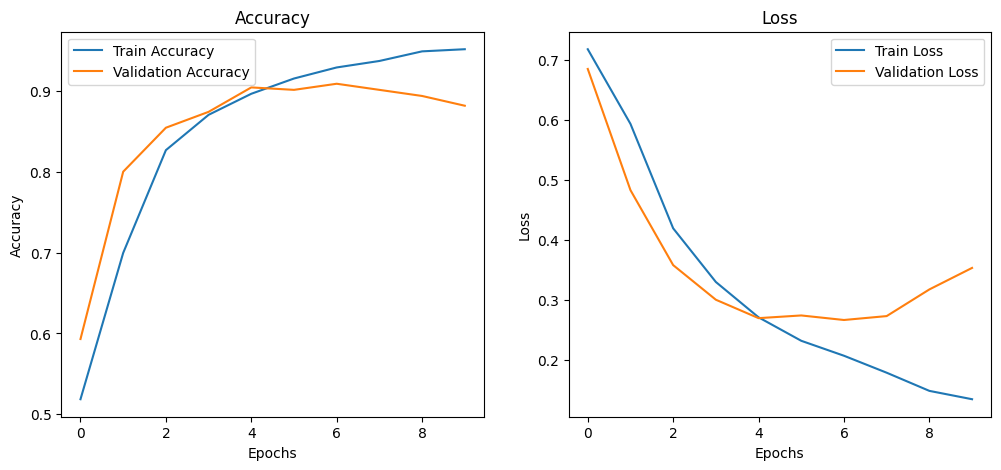

In [12]:
import matplotlib.pyplot as plt

# 학습 정확도 및 손실 시각화
plt.figure(figsize=(12, 5))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [13]:
defect_model.save('/content/defect_model.h5')
print("결함 여부 모델이 저장되었습니다.")

결함 여부 모델이 저장되었습니다.


### 옷 종류 분류 모델
- 결함 없는 이미지만 추출하여 옷의 종류를 분류하는 다중 분류 모델 설계

In [14]:
non_defected_data = train[train["defect_status"] == "non_defected"]

train_gen = data_gen.flow_from_dataframe(
    dataframe=non_defected_data,
    x_col="image_path",
    y_col="category",
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical",
    subset="training"
)

val_gen = data_gen.flow_from_dataframe(
    dataframe=non_defected_data,
    x_col="image_path",
    y_col="category",
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical",
    subset="validation"
)

# 다중 분류 모델 정의
def category_model(num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # 다중 분류
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

num_classes = len(non_defected_data["category"].unique())
category_model = category_model(num_classes)
history = category_model.fit(train_gen,validation_data=val_gen, epochs=10)


Found 5309 validated image filenames belonging to 17 classes.
Found 1327 validated image filenames belonging to 17 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


166/166 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - accuracy: 0.2084 - loss: 3.3819 - val_accuracy: 0.3044 - val_loss: 2.2057
Epoch 2/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 245s 1s/step - accuracy: 0.3151 - loss: 2.1758 - val_accuracy: 0.3760 - val_loss: 1.9885
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 275s 1s/step - accuracy: 0.3646 - loss: 1.9606 - val_accuracy: 0.4024 - val_loss: 1.8393
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.4066 - loss: 1.7808 - val_accuracy: 0.4197 - val_loss: 1.7596
Epoch 5/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 249s 1s/step - accuracy: 0.4530 - loss: 1.6437 - val_accuracy: 0.4408 - val_loss: 1.7024
Epoch 6/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.5001 - loss: 1.4830 - val_accuracy: 0.4378 - val_loss: 1.7148
Epoch 7/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.5327 - loss: 1.3346 - val_accuracy: 0.4431 - val_loss: 1.7348
Epoch 8/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step - accuracy: 0.5789 - loss: 1.1927 - val_accuracy: 0.442

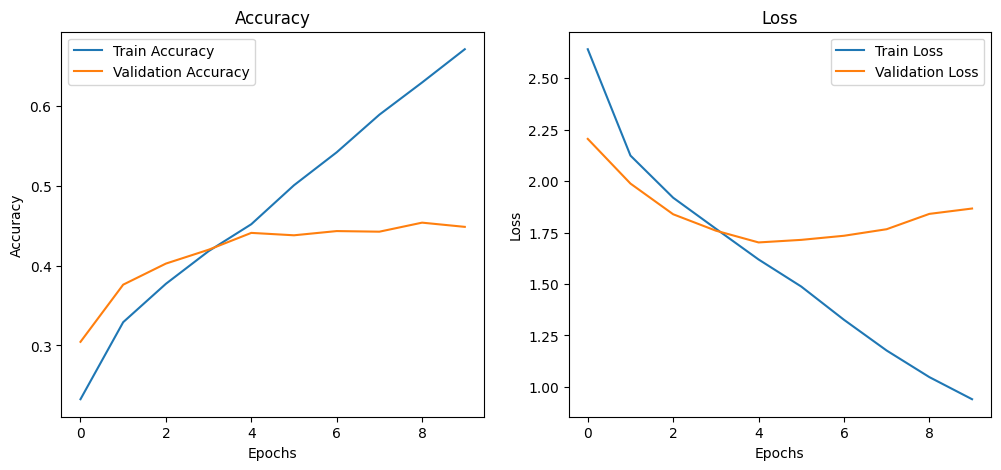

In [15]:
import matplotlib.pyplot as plt

# 학습 정확도 및 손실 시각화
plt.figure(figsize=(12, 5))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [16]:
category_model.save('/content/category_model.h5')
print("옷 종류 분류 모델이 저장되었습니다.")

옷 종류 분류 모델이 저장되었습니다.


# 4. 결과 해석 및 재활용 제안
### (1) 결함 여부 예측:
- 결함 여부를 모델로 판단.
- "defected"인 경우 재활용 불가능으로 태깅.

### (2) 옷 종류 분류:
- 결함이 없는 이미지에서 옷 종류를 예측.
- 옷의 종류에 따라 재활용 가능성 태깅

### 테스트 데이터 준비 및 모델 로드

In [17]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# 모델 경로
defect_model_path = "/content/defect_model.h5"  # 결함 여부 모델
category_model_path = "/content/category_model.h5"  # 옷 종류 모델

# 모델 로드
defect_model = load_model(defect_model_path)
category_model = load_model(category_model_path)

# 테스트 이미지 경로 및 레이블
test_images_dir = "/content/deepfashion/datasets/test_images"
test_labels = "/content/deepfashion/datasets/test_labels.csv"

# 클래스 매핑 (다중 분류 클래스에 대한 매핑)
category_classes = {v: k for k, v in train_gen.class_indices.items()}  # 역매핑
print(category_classes)

{0: 'Blouses_Shirts', 1: 'Cardigans', 2: 'Denim', 3: 'Dresses', 4: 'Graphic_Tees', 5: 'Jackets_Coats', 6: 'Jackets_Vests', 7: 'Leggings', 8: 'Pants', 9: 'Rompers_Jumpsuits', 10: 'Shirts_Polos', 11: 'Shorts', 12: 'Skirts', 13: 'Suiting', 14: 'Sweaters', 15: 'Sweatshirts_Hoodies', 16: 'Tees_Tanks'}


### 이미지 전처리 함수

In [18]:
def preprocess_image(image_path, target_size=(128, 128)):
    """이미지 전처리 함수"""
    image = load_img(image_path, target_size=target_size)  # 이미지 로드 및 크기 조정
    image = img_to_array(image) / 255.0  # 정규화
    return np.expand_dims(image, axis=0)  # 배치 차원 추가

### 결과 해석 및 재활용 제안 생성

In [19]:
def analyze_and_propose(image_path):
    """결함 여부 판단 및 재활용 제안"""
    # 이미지 전처리
    image = preprocess_image(image_path)

    # 결함 여부 예측
    defect_prediction = defect_model.predict(image)[0][0]  # 0: 결함 없음, 1: 결함 있음
    defect_status = "defected" if defect_prediction >= 0.5 else "non_defected"

    # 결함이 없으면 옷 종류 예측
    if defect_status == "non_defected":
        category_prediction = category_model.predict(image)
        category_index = np.argmax(category_prediction)
        category = category_classes.get(category_index, "Unknown")
        recyclable = "Yes"  # 결함이 없으면 기본적으로 재활용 가능
    else:
        category = "Not applicable"
        recyclable = "No"  # 결함이 있으면 재활용 불가

    # 결과 출력
    return {
        "image_path": image_path,
        "defect_status": defect_status,
        "category": category,
        "recyclable": recyclable,
    }


### 테스트 이미지 분석 및 출력

In [20]:
import pandas as pd

# 테스트 데이터 로드
test_df = pd.read_csv(test_labels)

# 테스트 데이터 샘플링 (10개 이미지만 선택)
sample_test_df = test_df.sample(n=10, random_state=42)  # 무작위 10개 선택

# 테스트 이미지 분석
results = []
for idx, row in sample_test_df.iterrows():
    image_path = row["image_path"]
    result = analyze_and_propose(image_path)
    results.append(result)

# 결과 출력
for res in results[:10]:  # 상위 10개 결과 출력
    print(res)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
{'image_path': '/content/deepfashion/datasets/train_images/MEN-Pants-id_00006908-01_1_front.png', 'defect_status': 'defected', 'category': 'Not applicable', 'recyclable': 'No'}
{'image_path': '/content/deepfashion/datasets/train_images/MEN-Sweatshirts_Hoodies-id_00002315-01_1_front.png', 'defect_status': 'non_defe

### 결과 CSV 저장

In [21]:
# 결과 저장
results_df = pd.DataFrame(results)
results_df.to_csv("/content/recycling_proposals.csv", index=False)
print("결과가 저장되었습니다: /content/recycling_proposals.csv")

결과가 저장되었습니다: /content/recycling_proposals.csv
